**Ce Notebook permet de tester le modèle catboost avec un seuil de prédiction afin de limiter les faux positifs**

In [11]:
import subprocess

def install_requirements_from_github(url):
    # Télécharger le fichier requirements.txt depuis GitHub
    subprocess.run(['curl', '-o', 'requirements.txt', url])

    # Installer les bibliothèques listées dans requirements.txt
    subprocess.run(['pip', 'install', '-r', 'requirements.txt'])

# URL du fichier requirements.txt sur GitHub
requirements_url = 'https://raw.githubusercontent.com/bourydamien/projet_scoring/master/requirements.txt'

# Appeler la fonction pour installer les bibliothèques
install_requirements_from_github(requirements_url)

In [12]:
pip install shap

In [13]:
pip install pyngrok

In [14]:
import numpy as np
import pandas as pd
import glob
import optuna
#import cuml
#from cuml.linear_model import LogisticRegression
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
import time
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool, utils

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.sklearn
import gc
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import gdown
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from scipy.stats import skew
from google.colab import drive
import catboost
from catboost.utils import get_gpu_device_count
import os
import pickle
import joblib
from datetime import datetime
import json
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score


import mlflow.catboost



from catboost.utils import get_gpu_device_count

from sklearn.metrics import confusion_matrix
import shap

In [15]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
model_path = '/content/drive/MyDrive/Colab Notebooks/data_scoring/model_20240927_111207/best_model_weighted_class.cbm'


Création d'un dossier pour l'optimisation du seuil

In [17]:


scoring_folder = '/content/drive/MyDrive/Colab Notebooks/data_scoring/optimisation_seuil'

# Créer un sous-dossier avec la date et l'heure
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_folder = f'{scoring_folder}/model_{timestamp}'
os.makedirs(model_folder, exist_ok=True)



Chargement des fichiers d'entrainement

In [18]:
def download_data():
    # URLs des fichiers sur Google Drive
    train_url = 'https://drive.google.com/uc?id=1oElrtY8GECJGLFpcB8-P5H5nwTvfhcYk'
    test_url = 'https://drive.google.com/uc?id=1OnzEHhlJqNASnP1FHiHPnb2554agP9cZ'

    # Chemins de sauvegarde locaux
    train_output = 'train_data.csv'
    test_output = 'test_data.csv'

    # Télécharger les fichiers
    gdown.download(train_url, train_output, quiet=False)
    gdown.download(test_url, test_output, quiet=False)

# Appeler la fonction pour télécharger les données
download_data()

Downloading...
From (original): https://drive.google.com/uc?id=1oElrtY8GECJGLFpcB8-P5H5nwTvfhcYk
From (redirected): https://drive.google.com/uc?id=1oElrtY8GECJGLFpcB8-P5H5nwTvfhcYk&confirm=t&uuid=32894e23-d043-47d9-92da-998c020e6570
To: /content/train_data.csv
100%|██████████| 166M/166M [00:03<00:00, 42.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OnzEHhlJqNASnP1FHiHPnb2554agP9cZ
To: /content/test_data.csv
100%|██████████| 26.6M/26.6M [00:00<00:00, 30.1MB/s]


Chargement des données

In [19]:
#importation des données de train
app_train = pd.read_csv('/content/train_data.csv')
print('Training data shape: ', app_train.shape)
# Testing data features
app_test = pd.read_csv('/content/test_data.csv')
print('Testing data shape: ', app_test.shape)

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [20]:
from pyngrok import ngrok

# Démarrer l'UI MLflow sur le port 5000
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminer les tunnels ngrok existants (le cas échéant)
ngrok.kill()

# Si tu as un jeton d'authentification Ngrok, définis-le ici (optionnel)
NGROK_AUTH_TOKEN = "2mQhc8YiUoUK6QUqgKogSMKs4rA_3Xp1NRRb6KNvokubaWec4"  # Facultatif
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Créer un tunnel HTTP sur le port 5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://46ab-34-73-255-96.ngrok-free.app


Métrique personnalisée

In [21]:

def weighted_cost_metric(y_true, y_pred, fp_weight=10, fn_weight=1):
    """
    Fonction de coût personnalisée qui pénalise les faux positifs (FP) avec un poids plus élevé.

    :param y_true: Labels réels.
    :param y_pred: Labels prédits.
    :param fp_weight: Poids appliqué aux faux positifs.
    :param fn_weight: Poids appliqué aux faux négatifs.
    :return: Score du coût pondéré.
    """
    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût total
    weighted_cost = (fp_weight * fp) + (fn_weight * fn)

    return weighted_cost

Feature engeneering

In [22]:
def add_domain_features_with_anomaly(train_df, test_df):
    """
    Ajoute une colonne d'anomalie pour 'DAYS_EMPLOYED' et remplace les valeurs anormales,
    puis applique les transformations sur les DataFrames de train et de test.

    Args:
        train_df (pd.DataFrame): Le DataFrame d'entraînement.
        test_df (pd.DataFrame): Le DataFrame de test.

    Returns:
        train_df (pd.DataFrame): Le DataFrame d'entraînement avec les modifications.
        test_df (pd.DataFrame): Le DataFrame de test avec les modifications.
    """

    # Ajouter une colonne 'DAYS_EMPLOYED_ANOM' (anomalie) et remplacer 365243 par NaN
    for df in [train_df, test_df]:
        df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243
        df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

        # Ajouter les colonnes dérivées
        df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
        df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
        df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
        df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    print("Nouvelles colonnes ajoutées et anomalies corrigées")

    return train_df, test_df

In [23]:
app_train, app_test = add_domain_features_with_anomaly(app_train,app_test)

Nouvelles colonnes ajoutées et anomalies corrigées


Encodage des variables

In [24]:
def encode_categorical_variables(train_data, test_data, target_column, model_folder):
    """
    Encode les variables catégorielles en deux étapes :
    1. Utilise Label Encoding pour les colonnes avec 2 catégories ou moins.
    2. Utilise One-Hot Encoding pour toutes les autres variables catégorielles.
    Puis aligne les colonnes des jeux de données et réinsère la variable cible.

    Les objets utilisés pour l'encodage (LabelEncoder, colonnes One-Hot) sont enregistrés dans `model_folder`.

    :param train_data: DataFrame des données d'entraînement
    :param test_data: DataFrame des données de test
    :param target_column: Nom de la colonne cible dans les données d'entraînement
    :param model_folder: Dossier où enregistrer les objets d'encodage
    :return: DataFrames transformés (train_data, test_data)
    """

    # Extraire la variable cible
    train_labels = train_data[target_column]

    # Initialiser le label encoder
    le = LabelEncoder()
    le_count = 0
    label_encoded_columns = []

    # Appliquer le Label Encoding pour les colonnes avec 2 catégories ou moins
    for col in train_data:
        if train_data[col].dtype == 'object':
            # Si 2 catégories ou moins
            if len(list(train_data[col].unique())) <= 2:
                # Entraîner le label encoder sur les données d'entraînement
                le.fit(train_data[col])
                # Transformer les colonnes d'entraînement et de test
                train_data[col] = le.transform(train_data[col])
                test_data[col] = le.transform(test_data[col])

                le_count += 1
                label_encoded_columns.append(col)

    print(f'{le_count} colonnes ont été label encodées.')

    # Si des colonnes ont été label encodées, enregistrer le LabelEncoder
    if label_encoded_columns:
        with open(os.path.join(model_folder, 'label_encoder.pkl'), 'wb') as f:
            pickle.dump(le, f)

        # Enregistrer la liste des colonnes label encodées
        with open(os.path.join(model_folder, 'label_encoded_columns.pkl'), 'wb') as f:
            pickle.dump(label_encoded_columns, f)

    # Appliquer le One-Hot Encoding sur toutes les autres colonnes catégorielles
    train_data = pd.get_dummies(train_data)
    test_data = pd.get_dummies(test_data)

    # Enregistrer les colonnes utilisées pour le One-Hot Encoding
    with open(os.path.join(model_folder, 'one_hot_columns.pkl'), 'wb') as f:
        pickle.dump(train_data.columns.tolist(), f)

    # Aligner les colonnes des jeux de données d'entraînement et de test
    train_data, test_data = train_data.align(test_data, join='inner', axis=1)

    # Réinsérer la colonne cible dans le jeu d'entraînement
    train_data[target_column] = train_labels

    print('Forme des données d\'entraînement après One-Hot Encoding et alignement: ', train_data.shape)
    print('Forme des données de test après One-Hot Encoding et alignement: ', test_data.shape)

    return train_data, test_data



In [25]:
app_train , app_test = encode_categorical_variables(app_train, app_test, "TARGET", model_folder)

3 colonnes ont été label encodées.
Forme des données d'entraînement après One-Hot Encoding et alignement:  (307511, 245)
Forme des données de test après One-Hot Encoding et alignement:  (48744, 244)


Transformations mathématiques

In [26]:
def apply_boxcox_transformation(train_data, test_data, skew_threshold=0.75, save_path=model_folder):
    """
    Applique la transformation Box-Cox sur les colonnes numériques du DataFrame qui sont asymétriques (skewed)
    dans les jeux d'entraînement et de test, et enregistre les informations utiles (colonnes transformées et lambdas).

    :param train_data: DataFrame d'entraînement
    :param test_data: DataFrame de test
    :param skew_threshold: Seuil de skewness pour décider de l'application de la transformation Box-Cox
    :param save_path: Chemin où enregistrer les informations du modèle (colonnes et lambdas)
    :return: DataFrames transformés (train_data, test_data) et liste des colonnes transformées avec lambda
    """

    # Sélectionner les colonnes numériques dans les deux datasets
    numeric_cols = train_data.select_dtypes(include=[np.number]).columns

    # Initialiser une liste pour garder la trace des colonnes transformées
    transformed_cols = []
    lambda_params = {}

    # Appliquer la transformation sur chaque colonne numérique
    for col in numeric_cols:
        # Vérifier que toutes les valeurs dans les deux jeux de données sont strictement positives
        if (train_data[col] > 0).all() and (test_data[col] > 0).all():
            # Calculer la skewness sur le jeu d'entraînement
            col_skew = skew(train_data[col])

            # Appliquer Box-Cox si l'asymétrie dépasse le seuil
            if abs(col_skew) > skew_threshold:
                # Appliquer la transformation Box-Cox sur le jeu d'entraînement
                train_data[col], fitted_lambda = boxcox(train_data[col])

                # Appliquer la transformation Box-Cox sur le jeu de test avec le même lambda
                test_data[col] = boxcox(test_data[col], lmbda=fitted_lambda)

                # Ajouter la colonne transformée et le lambda à la liste
                transformed_cols.append(col)
                lambda_params[col] = fitted_lambda

    # Afficher les colonnes transformées et les paramètres lambda utilisés
    print(f"Colonnes transformées avec Box-Cox : {transformed_cols}")
    print(f"Paramètres lambda utilisés : {lambda_params}")

    # Sauvegarder les colonnes transformées et les paramètres lambda dans des fichiers JSON
    with open(f'{save_path}/transformed_columns.json', 'w') as f:
        json.dump(transformed_cols, f)

    with open(f'{save_path}/lambda_params.json', 'w') as f:
        json.dump(lambda_params, f)

    return train_data, test_data, transformed_cols, lambda_params

In [27]:
train_data, test_data, transformed_cols, lambda_params = apply_boxcox_transformation(app_train,app_test, save_path=model_folder)

Colonnes transformées avec Box-Cox : ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'CREDIT_INCOME_PERCENT']
Paramètres lambda utilisés : {'AMT_INCOME_TOTAL': -0.09313337858337999, 'AMT_CREDIT': 0.19208190760257246, 'REGION_POPULATION_RELATIVE': 0.26957001547446924, 'CREDIT_INCOME_PERCENT': 0.13555837759354478}


Normalisation des données

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

def normalize_train_test(train_data, test_data, save_path=model_folder):
    """
    Normalise les données d'entraînement et de test en ajustant le scaler sur les données d'entraînement
    et enregistre les paramètres de standardisation pour réutilisation dans le pipeline d'inférence.

    :param train_data: DataFrame d'entraînement
    :param test_data: DataFrame de test
    :param save_path: Chemin où enregistrer le scaler et les informations de normalisation
    :return: DataFrames normalisés (train_features_scaled, test_features_scaled)
    """

    # Séparer la colonne TARGET des données d'entraînement
    train_target = train_data['TARGET']
    train_features = train_data.drop(columns=['TARGET'])

    # Initialiser le scaler
    scaler = StandardScaler()

    # Ajuster le scaler sur les données d'entraînement et transformer les données d'entraînement
    train_features_scaled = scaler.fit_transform(train_features)

    # Transformer les données de test
    test_features_scaled = scaler.transform(test_data)

    # Convertir les données normalisées en DataFrame
    train_features_scaled = pd.DataFrame(train_features_scaled, columns=train_features.columns)
    test_features_scaled = pd.DataFrame(test_features_scaled, columns=test_data.columns)

    # Ajouter la colonne TARGET aux données d'entraînement normalisées
    train_features_scaled['TARGET'] = train_target.values

    # Sauvegarder le scaler pour réutilisation
    scaler_path = f'{save_path}/scaler.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"Scaler sauvegardé à : {scaler_path}")

    return train_features_scaled, test_features_scaled


In [29]:
app_train , app_test = normalize_train_test(train_data,test_data, save_path=model_folder)

Scaler sauvegardé à : /content/drive/MyDrive/Colab Notebooks/data_scoring/optimisation_seuil/model_20241007_093032/scaler.pkl


chargement du modèle

In [30]:
def load_model(model_path):
    """
    Charge le modèle CatBoost à partir du chemin spécifié..
    """
    model = CatBoostClassifier()
    model.load_model(model_path)
    print("modèle chargé")
    return model

In [31]:
model = load_model(model_path)

modèle chargé


In [32]:


def compare_model_runs(model, liste_seuils, experiment_name, data, target, model_folder):
    """
    Compare les performances du modèle avec différents seuils de décision.

    :param model: Instance du modèle CatBoost.
    :param liste_seuils: Liste des seuils de probabilité à tester.
    :param experiment_name: Nom de l'expérience pour MLflow.
    :param data: DataFrame contenant les données.
    :param target: Nom de la colonne cible dans le DataFrame.
    :param model_folder: Dossier pour stocker les fichiers créés.
    :return: DataFrame récapitulative des performances et importances des features.
    """
    results = []

    # Séparer X et y
    X = data.drop(columns=[target])
    y = data[target]

    # Créer un dossier pour stocker les résultats
    os.makedirs(model_folder, exist_ok=True)

    for seuil in liste_seuils:
        print(f"L'expérience essaie le seuil : {seuil}")
        start_time = time.time()

        # Faire des prédictions de probabilité
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= seuil).astype(int)

        # Calculer les métriques
        auc = roc_auc_score(y, y_proba)
        accuracy = accuracy_score(y, y_pred)
        cost = weighted_cost_metric(y, y_pred)

        # Temps de calcul
        end_time = time.time()  # Fin du chronomètre
        elapsed_time = end_time - start_time  # Temps écoulé en secondes

        # Stocker les résultats
        results.append({
            'seuil': seuil,
            'auc': auc,  # Ajout de l'AUC
            'accuracy': accuracy,
            'weighted_cost': cost,
            'elapsed_time': elapsed_time  # Ajouter le temps écoulé
        })

        # Nom de l'expérience pour MLflow
        run_name = f"{experiment_name}_seuil_{seuil}"
        mlflow.set_experiment(experiment_name=experiment_name)
        # Commencer un nouveau run MLflow
        with mlflow.start_run(run_name=run_name):
            mlflow.log_param("seuil décision", seuil)
            mlflow.log_metric("AUC", auc)
            mlflow.log_metric("Accuracy", accuracy)
            mlflow.log_metric("Weighted Cost", cost)
            mlflow.log_metric("Elapsed Time", elapsed_time)

            # Enregistrer les importances des features
            feature_importances = model.get_feature_importance()
            feature_importances_path = os.path.join(model_folder, f"feature_importances_{seuil}.json")

            # Sauvegarder les importances dans un fichier JSON
            with open(feature_importances_path, 'w') as f:
                json.dump(feature_importances.tolist(), f)

            # Logger le fichier d'importances
            mlflow.log_artifact(feature_importances_path)

    # Créer un DataFrame récapitulatif des performances
    results_df = pd.DataFrame(results)

    # Enregistrer le DataFrame sous forme de CSV dans le dossier spécifié
    results_csv_path = os.path.join(model_folder, "results_comparison.csv")
    results_df.to_csv(results_csv_path, index=False)

    # Afficher le DataFrame récapitulatif
    print(results_df)

    return results_df





In [33]:
experiment_name="Comparaison des différents seuils de décision"
liste_seuils = [round(i, 2) for i in np.arange(0.5, 0.76, 0.01)]
target = "TARGET"
data = app_train

In [34]:
result_df = compare_model_runs(model, liste_seuils, experiment_name, data, target, model_folder)

L'expérience essaie le seuil : 0.5


2024/10/07 09:31:38 INFO mlflow.tracking.fluent: Experiment with name 'Comparaison des différents seuils de décision' does not exist. Creating a new experiment.


L'expérience essaie le seuil : 0.51
L'expérience essaie le seuil : 0.52
L'expérience essaie le seuil : 0.53
L'expérience essaie le seuil : 0.54
L'expérience essaie le seuil : 0.55
L'expérience essaie le seuil : 0.56
L'expérience essaie le seuil : 0.57
L'expérience essaie le seuil : 0.58
L'expérience essaie le seuil : 0.59
L'expérience essaie le seuil : 0.6
L'expérience essaie le seuil : 0.61
L'expérience essaie le seuil : 0.62
L'expérience essaie le seuil : 0.63
L'expérience essaie le seuil : 0.64
L'expérience essaie le seuil : 0.65
L'expérience essaie le seuil : 0.66
L'expérience essaie le seuil : 0.67
L'expérience essaie le seuil : 0.68
L'expérience essaie le seuil : 0.69
L'expérience essaie le seuil : 0.7
L'expérience essaie le seuil : 0.71
L'expérience essaie le seuil : 0.72
L'expérience essaie le seuil : 0.73
L'expérience essaie le seuil : 0.74
L'expérience essaie le seuil : 0.75
    seuil       auc  accuracy  weighted_cost  elapsed_time
0    0.50  0.783246  0.920338          2817

In [36]:
fi_folder = '/content/drive/MyDrive/Colab Notebooks/data_scoring/model_20240927_111207/'
fi_path = os.path.join(fi_folder, "feature_importances_weighted_class.csv")
result_df = pd.read_csv(fi_path)


In [37]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGboost Features (avg over folds)')
    plt.tight_layout()

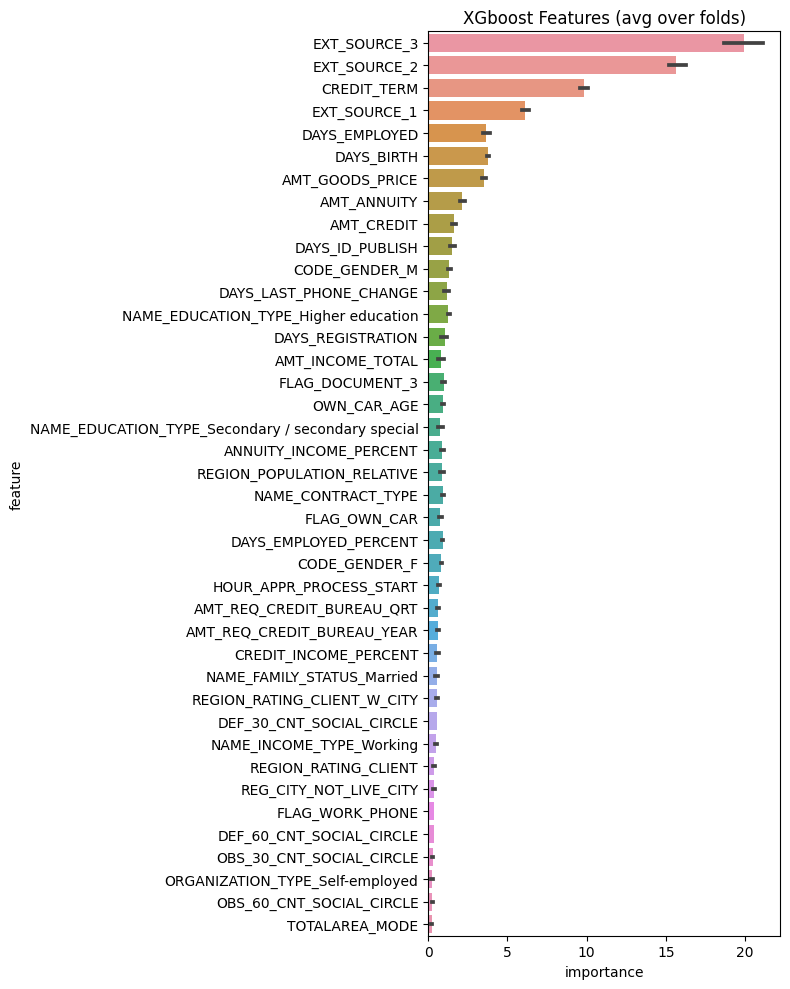

In [38]:
display_importances(result_df)

In [39]:
result_df.to_csv(os.path.join(scoring_folder, "resultats_seuils.csv"), index=False)

In [43]:
test_data = app_test

# Créer un explainer SHAP pour CatBoost
explainer = shap.TreeExplainer(model)

# Calculer les valeurs SHAP pour chaque individu
shap_values = explainer.shap_values(test_data)
# visualisez les valeurs de shap
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10,:], test_data.iloc[10,:])